In [0]:
import keras
keras.__version__

'2.2.4'

# 循环神经网络的高级用法

This notebook contains the code samples found in Chapter 6, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

本节将介绍提高循环神经网络的性能和泛化能力的三种高级技巧。学完本节，你将会掌握 用 Keras 实现循环网络的大部分内容。我们将在温度预测问题中介绍这三个概念。在这个问题中， 数据点时间序列来自建筑物屋顶安装的传感器，包括温度、气压、湿度等，你将要利用这些数 据来预测最后一个数据点24小时之后的温度。这是一个相当有挑战性的问题，其中包含许多处 理时间序列时经常遇到的困难。

我们将会介绍以下三种技巧。

* 循环 dropout（recurrent dropout）。这是一种特殊的内置方法，在循环层中使用 dropout来降低过拟合。
* 堆叠循环层（stacking recurrent layers）。这会提高网络的表示能力（代价是更高的计算负荷）。
* 双向循环层（bidirectional recurrent layer）。将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题。

## A temperature forecasting problem

到目前为止，我们遇到的唯一一种序列数据就是文本数据，比如 IMDB 数据集和路透社 数据集。但除了语言处理，其他许多问题中也都用到了序列数据。在本节的所有例子中，我 们将使用一个天气时间序列数据集，它由德国耶拿的马克思 • 普朗克生物地球化学研究所的气象站记录。

在这个数据集中，每 10 分钟记录 14 个不同的量（比如气温、气压、湿度、风向等），其中包含多年的记录。原始数据可追溯到 2003 年，但本例仅使用 2009—2016 年的数据。这个数据集非常适合用来学习处理数值型时间序列。我们将会用这个数据集来构建模型，输入最近的一 些数据（几天的数据点），可以预测 24 小时之后的气温。

备注：我们下载好了，文件路径： 'data/jena_climate_2009_2016.csv'

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2019-04-09 10:02:51--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.134.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.134.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  35.7MB/s    in 0.4s    

2019-04-09 10:02:52 (35.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


Let's take a look at the data:

In [3]:
import os

data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
print(len(lines[1]))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
101


In [7]:
print(len(lines[0]))

101


In [8]:
lines[0]
# 整体为一个str

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [6]:
print(len(header))

15


接下来，将 420 551 行数据转换成一个 Numpy 数组。

In [4]:
head1 = lines[0].split(',')
print(head1)
head2 = lines[0].split(',')[1:]
print(head2)
# head2不包含时间

['01.01.2009 00:10:00', '996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']
['996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']


In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
float_data.shape

(420551, 14)

比如，温度随时间的变化如下图所示（单位：摄氏度）

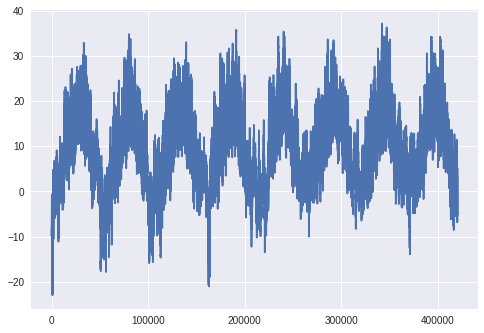

In [9]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)（温度（单位：摄氏度））
plt.plot(range(len(temp)), temp)
plt.show()


在这张图中，你可以清楚地看 到温度每年的周期性变化。

上图给出了前 10 天温度数据的图像。因为每 10 分钟记录一个数据，所以每天有 144 个 数据点。

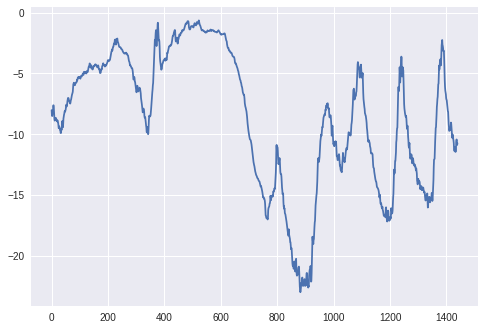

In [10]:
# 绘制前 10 天的温度时间序列
plt.plot(range(1440), temp[:1440])
plt.show()


在这张图中，你可以看到每天的周期性变化，尤其是最后 4 天特别明显。另外请注意，这10天一定是来自于很冷的冬季月份。

如果你想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？我们来寻找这个问题的答案。

## 准备数据


这个问题的确切表述如下：一个时间步是 10 分钟，每 steps 个时间步采样一次数据，给定过去 lookback 个时间步之内的数据，能否预测 delay 个时间步之后的温度？用到的参数值 如下。

* lookback = 720：给定过去 5 天内的观测数据。
* steps = 6：观测数据的采样频率是每小时一个数据点。
* delay = 144：目标是未来 24 小时之后的数据。 

开始之前，你需要完成以下两件事。
* 将数据预处理为神经网络可以处理的格式。这很简单。数据已经是数值型的，所以不需要做向量化。但数据中的每个时间序列位于不同的范围（比如温度通道位于 -20 到 +30 之间，但气压大约在 1000 毫巴上下）。你需要对每个时间序列分别做标准化，让它们在相似的范围内都取较小的值。
* 编写一个 Python 生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。因为数据集中的样本是高度冗余的（对于第 N 个样本和第 N+1 个样本，大部分时间步都是相同的），所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本。

预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前200 000 个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。

In [0]:
# 标准化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [12]:
mean.shape

(14,)


代码清单给出了将要用到的生成器。它生成了一个元组 (samples, targets)，其 中 samples 是输入数据的一个批量，targets 是对应的目标温度数组。生成器的参数如下。

* data：浮点数数据组成的原始数组，在上面的代码中将其标准化。
* lookback：输入数据应该包括过去多少个时间步。
* delay：目标应该在未来多少个时间步之后。
* min_index 和 max_index：data 数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试。
* shuffle：是打乱样本，还是按顺序抽取样本。
* batch_size：每个批量的样本数。
* step：数据采样的周期（单位：时间步）。我们将其设为 6，为的是每小时抽取一个数据点。

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


下面，我们使用这个抽象的 generator 函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前200 000 个时间步，验证生成器读取随后的 100 000 个时间步，测试生成器读取剩下的时间步。

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
# 为了查看整个验证集，需要 从 val_gen 中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
# 为了查看整个测试集，需要从 test_gen 中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [15]:
print(val_steps)
print(test_steps)

769
930


## 一种基于常识的、非机器学习的基准方法


开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。 它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能 表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。 一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含90% 的类别 A 实例和 10% 的类别 B 实例，那么分类任务的一种基于常识的方法就是对新样本 始终预测类别“A”。这种分类器的总体精度为 90%，因此任何基于学习的方法在精度高于 90% 时才能证明其有效性。有时候，这样基本的基准方法可能很难打败。

本例中，我们可以放心地假设，温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终预测 24 小时后的温度 等于现在的温度。我们使用平均绝对误差（MAE）指标来评估这种方法。

In [0]:
# np.mean(np.abs(preds - targets))

下面是评估的循环代码。

In [16]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


得到的 MAE 为 0.29。因为温度数据被标准化成均值为 0、标准差为 1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为0.29×temperature_std 摄氏度，即 2.57℃。绝对误差还是相当大的。接下来的任务是利用深度学习知识来改进结果。

## 一种基本的机器学习方法

在尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的；同样，在开始研究 复杂且计算代价很高的模型（比如 RNN）之前，尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

下面的代码清单给出了一个密集连接模型，首先将数据展平，然后通过两个Dense 层并运行。 注意，最后一个 Dense 层没有使用激活函数，这对于回归问题是很常见的。我们使用 MAE 作 为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。

In [17]:
float_data.shape[-1]

14

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 1.3536 - val_loss: 0.6234
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4328 - val_loss: 0.3229
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2921 - val_loss: 0.3706
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2670 - val_loss: 0.3082
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2512 - val_loss: 0.3147
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2417 - val_loss: 0.3071
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2338 - val_loss: 0.3175
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2279 - val_loss: 0.3441
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2244 - val_loss: 0.3385
Epoch 10/20
500/500 [=============

我们来显示验证和训练的损失曲线

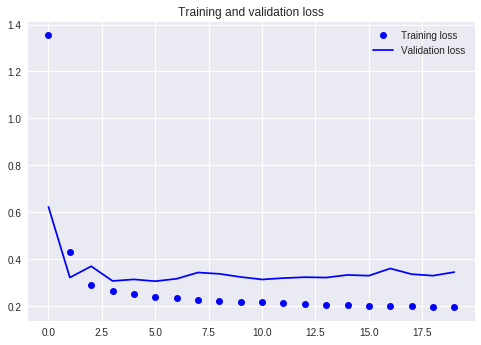

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
val_loss
# 超过基准0.29很多

[0.6234067886757758,
 0.3228507168949503,
 0.3705586079890768,
 0.30815840168082204,
 0.3147353538020147,
 0.30708284195517377,
 0.31745920241634773,
 0.344110320914435,
 0.3384960877657014,
 0.3250617322031171,
 0.3144787116017391,
 0.3203173623709747,
 0.32419383329652995,
 0.322666507480746,
 0.333705570199981,
 0.33059488489293776,
 0.3612397568075105,
 0.33714979763478237,
 0.33068844934220587,
 0.3457609104629611]


部分验证损失接近不包含学习的基准方法，但这个结果并不可靠。这也展示了首先建立这个基准方法的优点，事实证明，超越这个基准并不容易。我们的常识中包含了大量有价值的信息，而机器学习模型并不知道这些信息。

你可能会问，如果从数据到目标之间存在一个简单且表现良好的模型（即基于常识的基准 方法），那为什么我们训练的模型没有找到这个模型并进一步改进呢？原因在于，这个简单的解决方案并不是训练过程所要寻找的目标。我们在模型空间（即假设空间）中搜索解决方案，这个模型空间是具有我们所定义的架构的所有两层网络组成的空间。这些网络已经相当复杂了。

如果你在一个复杂模型的空间中寻找解决方案，那么可能无法学到简单且性能良好的基准方法， 虽然技术上来说它属于假设空间的一部分。通常来说，这对机器学习是一个非常重要的限制： 如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到 简单问题的简单解决方案的。

## 第一个循环网络基准


第一个全连接方法的效果并不好，但这并不意味着机器学习不适用于这个问题。前一个方法首先将时间序列展平，这从输入数据中删除了时间的概念。我们来看一下数据本来的样子： 它是一个序列，其中因果关系和顺序都很重要。我们将尝试一种循环序列处理模型，它应该特别适合这种序列数据，因为它利用了数据点的时间顺序，这与第一个方法不同。

我们将使用 Chung 等人在2014 年开发的 GRU 层，而不是上一节介绍的 LSTM 层。门控循环单元（GRU，gated recurrent unit）层的工作原理与 LSTM 相同。但它做了一些简化，因此运行的计算代价更低（虽然表示能力可能不如 LSTM）。机器学习中到处可以见到这种计算代价与表示能力之间的折中。

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 117s 234ms/step - loss: 0.3121 - val_loss: 0.2722
Epoch 2/20
500/500 [==============================] - 116s 231ms/step - loss: 0.2862 - val_loss: 0.2677
Epoch 3/20
500/500 [==============================] - 115s 230ms/step - loss: 0.2801 - val_loss: 0.2670
Epoch 4/20
500/500 [==============================] - 115s 231ms/step - loss: 0.2751 - val_loss: 0.2656
Epoch 5/20
500/500 [==============================] - 114s 229ms/step - loss: 0.2711 - val_loss: 0.2709
Epoch 6/20
500/5

Let look at our results:

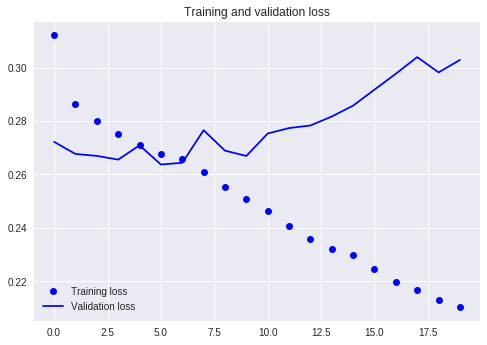

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


效果好多了！远优于基于常识的基准方法。这证明了机器学习的价值，也证明了循环网络与序列展平的密集网络相比在这种任务上的优势。

新的验证 MAE 约为 0.265（在开始显著过拟合之前），反标准化转换成温度的平均绝对误差为 2.35℃。与最初的误差 2.57℃相比，这个结果确实有所提高，但可能仍有改进的空间。

## 使用循环 dropout 来降低过拟合


从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。我们已经学过降低过拟合的一种经典技术——dropout，即将某一层的输入单元随机设为 0，其目的是打破该层训练数据中的偶然相关性。但在循环网络中如何正确地使用 dropout，这并不是一个简单的问题。人们早就知道，在循环层前面应用 dropout，这种正则化会妨碍学习过程，而不是有所帮助。2015 年，在关于贝叶斯深度学习的博士论文中，Yarin Gal 确定了在循环网络中使用 dropout 的正确方法：对每个时间步应该使用相同的 dropout 掩码（dropout mask，相同模式的舍弃单元），而不是让 dropout 掩码随着时间步的增加而随机变化。此外，为了对 GRU、LSTM 等循环层得到的表示做正则化，应该将不随时间变化的 dropout 掩码应用于层的内部循环激活（叫作循环 dropout 掩码）。对每个时间步使用相同的 dropout 掩码，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的 dropout 掩码则会破坏这个误差信号，并且不利于学习过程。

Yarin Gal 使用 Keras 开展这项研究，并帮助将这种机制直接内置到 Keras 循环层中。Keras 的每个循环层都有两个与 dropout 相关的参数：一个是dropout，它是一个浮点数，指定该层输入单元的 dropout 比率；另一个是 recurrent_dropout，指定循环单元的 dropout 比率。我们向 GRU 层中添加 dropout和循环 dropout，看一下这么做对过拟合的影响。因为使用 dropout 正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的 2 倍。

In [21]:
help(layers.GRU)

Help on class GRU in module keras.layers.recurrent:

class GRU(RNN)
 |  Gated Recurrent Unit - Cho et al. 2014.
 |  
 |  There are two variants. The default one is based on 1406.1078v3 and
 |  has reset gate applied to hidden state before matrix multiplication. The
 |  other one is based on original 1406.1078v1 and has the order reversed.
 |  
 |  The second variant is compatible with CuDNNGRU (GPU-only) and allows
 |  inference on CPU. Thus it has separate biases for `kernel` and
 |  `recurrent_kernel`. Use `'reset_after'=True` and
 |  `recurrent_activation='sigmoid'`.
 |  
 |  # Arguments
 |      units: Positive integer, dimensionality of the output space.
 |      activation: Activation function to use
 |          (see [activations](../activations.md)).
 |          Default: hyperbolic tangent (`tanh`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      recurrent_activation: Activation function to use
 |          for the

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 132s 263ms/step - loss: 0.3414 - val_loss: 0.2736
Epoch 2/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3188 - val_loss: 0.2747
Epoch 3/40
500/500 [==============================] - 132s 263ms/step - loss: 0.3109 - val_loss: 0.2698
Epoch 4/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3060 - val_loss: 0.2691
Epoch 5/40
500/500 [==============================] - 131s 263ms/step - loss: 0.3035 - val_loss: 0.2674
Epoch 6/40
500/5

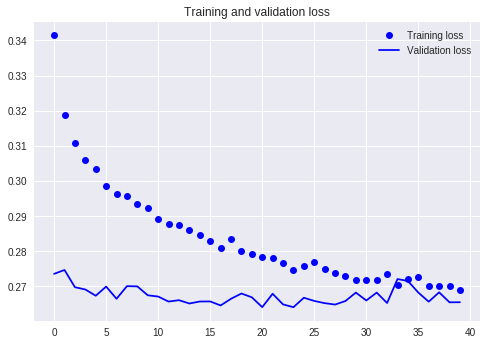

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

成功！前 30 个轮次不再过拟合。不过，虽然评估分数更加稳定，但最佳分数并没有比之前低很多。

## 循环层堆叠

模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机 器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用 dropout）。只要过拟合不是太严重，那么很可能是容量不足的问题。

增加网络容量的通常做法是增加每层单元数或增加层数。循环层堆叠（recurrent layer stacking）是构建更加强大的循环网络的经典方法，例如，目前谷歌翻译算法就是 7 个大型LSTM 层的堆叠——这个架构很大。

在 Keras 中逐个堆叠循环层，所有中间层都应该返回完整的输出序列（一个 3D 张量），而不是只返回最后一个时间步的输出。这可以通过指定return_sequences=True 来实现。

In [0]:
# samples, targets = next(val_gen)

In [27]:
# samples.shape

(128, 240, 14)

In [28]:
# targets.shape

(128,)

In [0]:
float_data.shape[-1]

14

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
# 4512=32*(14+32)+32=1504*3
# 18624=64*(32+64)+64=6208*3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 32)          4512      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 349s 697ms/step - loss: 0.3322 - val_loss: 0.2775
Epoch 2/40
500/500 [==============================] - 345s 690ms/step - loss: 0.3108 - val_loss: 0.2720
Epoch 3/40
500/500 [==============================] - 345s 689ms/step - loss: 0.3049 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 343s 686ms/step - loss: 0.3001 - val_loss: 0.2723
Epoch 5/40
500/500 [==============================] - 347s 693ms/step - loss: 0.2977 - val_loss: 0.2649
Epoch 6/40
500/500 [==============================] - 351s 702ms/step - loss: 0.2931 - val_loss: 0.2643
Epoch 7/40
500/500 [==============================] - 350s 700ms/step - loss: 0.2922 - val_loss: 0.2645
Epoch 8/40
500/500 [==============================] - 348s 695ms/step - loss: 0.2891 - val_loss: 0.2746
Epoch 9/40
500/500 [==============================] - 345s 689ms/step - loss: 0.2867 - val_loss: 0.2731
Epoch 10/40
500/500 [==============================] - 347s 695m

Let's take a look at our results:

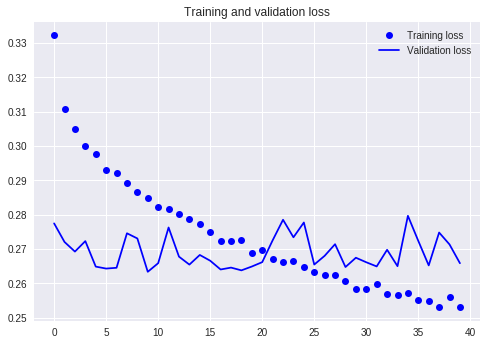

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

可以看到，添加一层的确对结果有所改进，但并不显著。我们可以得出两个结论。

* 因为过拟合仍然不是很严重，所以可以放心地增大每层的大小，以进一步改进验证损失。 但这么做的计算成本很高。
* 添加一层后模型并没有显著改进，所以你可能发现，提高网络能力的回报在逐渐减小。

## 使用双向 RNN


本节介绍的最后一种方法叫作 双向 RNN（bidirectional RNN）。双向RNN 是一种常见的 RNN 变体，它在某些任务上的性能比普通 RNN 更好。它常用于自然语言处理，可谓深度学习对自然语言处理的瑞士军刀。

RNN 特别依赖于顺序或时间，RNN 按顺序处理输入序列的时间步，而打乱时间步或反转 时间步会完全改变 RNN 从序列中提取的表示。正是由于这个原因，如果顺序对问题很重要（比如温度预测问题），RNN 的表现会很好。双向 RNN 利用了 RNN 的顺序敏感性：它包含两个普通 RNN，比如你已经学过的 GRU 层和 LSTM 层，每个 RN 分别沿一个方向对输入序列进行处理（时间正序和时间逆序），然后将它们的表示合并在一起。通过沿这两个方向处理序列，双向 RNN 能够捕捉到可能被单向 RNN 忽略的模式。

值得注意的是，本节的 RNN 层都是按时间正序处理序列（更早的时间步在前），这可能是一个随意的决定。至少，至今我们还没有尝试质疑这个决定。如果 RNN 按时间逆序处理输入序列（更晚的时间步在前），能否表现得足够好呢？我们在实践中尝试一下这种方法，看一下会发生什么。你只需要编写一个数据生成器的变体，将输入序列沿着时间维度反转（即将最后一行代码替换为 yield samples`[:, ::-1, :]`, targets）。本节第一个实验用到了一个单 GRU 层的网络，我们训练一个与之相同的网络，得到的结果后面代码所示。

In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 118s 236ms/step - loss: 0.4795 - val_loss: 0.4903
Epoch 2/20
500/500 [==============================] - 116s 232ms/step - loss: 0.4594 - val_loss: 0.4683
Epoch 3/20
500/500 [==============================] - 116s 233ms/step - loss: 0.4109 - val_loss: 0.4544
Epoch 4/20
500/500 [==============================] - 116s 231ms/step - loss: 0.3705 - val_loss: 0.4435
Epoch 5/20
500/500 [==============================] - 116s 232ms/step - loss: 0.3414 - val_loss: 0.4486
Epoch 6/20
500/500 [==============================] - 115s 231ms/step - loss: 0.3251 - val_loss: 0.4541
Epoch 7/20
500/500 [==============================] - 116s 233ms/step - loss: 0.3085 - val_loss: 0.4505
Epoch 8/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2996 - val_loss: 0.4400
Epoch 9/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2897 - val_loss: 0.4650
Epoch 10/20
500/500 [==============================] - 116s 232m

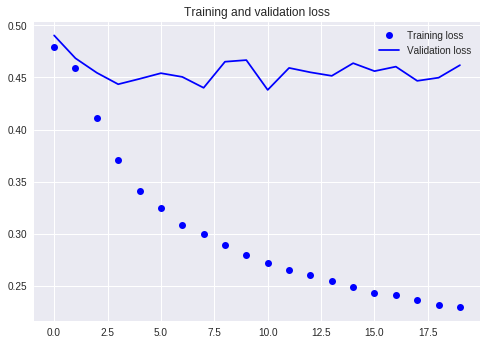

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# 可以看出效果非常差

逆序 GRU 的效果甚至比基于常识的基准方法还要差很多，这说明在本例中，按时间正序处理对成功解决问题很重要。这非常合理：GRU 层通常更善于记住最近的数据，而不是久远的数据，与更早的数据点相比，更靠后的天气数据点对问题自然具有更高的预测能力（这也是基于常识的基准方法非常强大的原因）。因此，按时间正序的模型必然会优于时间逆序的模型。重要的是，对许多其他问题（包括自然语言）而言，情况并不是这样：直觉上来看，一个单词对理解句子的重要性通常并不取决于它在句子中的位置。我们尝试对上一节 IMDB 示例中的 LSTM 应用相同的技巧。

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features（作为特征的单词个数）
max_features = 10000
# 在这么多单词之后截断文本（这些单词都属于前 max_features 个最常见的单词）
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences（将文本序列反转）
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
# 每个文本之间的顺序没有变，变的是一个文本内的顺序,即文本的开头变成了结尾
# 结尾变成了开头

In [31]:
len(x_train)

25000

In [35]:
len(x_train[0])

218

In [0]:
# Pad sequences（填充序列）
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 0s 0us/step
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 151s 8ms/step - loss: 0.5075 - acc: 0.7586 - val_loss: 0.3598 - val_acc: 0.8576
Epoch 2/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.3179 - acc: 0.8791 - val_loss: 0.5284 - val_acc: 0.7626
Epoch 3/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.2650 - acc: 0.9017 - val_loss: 0.3477 - val_acc: 0.8528
Epoch 4/10
20000/20000 [==============================] - 148s 7ms/step - loss: 0.2192 - acc: 0.9207 - val_loss: 0.4198 - val_acc: 0.8618
Epoch 5/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.2022 - acc: 0.9309 - val_loss: 0.4245 - val_acc: 0.8594
Epoch 6/10
20000/20000 [==============================] - 149s 7ms/step - loss: 0.1815 - acc: 0.9381 - val_loss: 0.3419 - val_acc: 0.8742
Epoch 7/10
20000/20000 [==============================] - 

模型性能与正序 LSTM 几乎相同。

值得注意的是，在这样一个文本数据集上，逆序处理的效果与正序处理一样好，这证实了一个假设：虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。重要的是，在逆序序列上训练的 RNN 学到的表示不同于在原始序列上学到的表示，正如在现实世界中，如果时间倒流（你的人生是第一天死去、最后一天出生），那么你的心智模型也会完全不同。在机器学习中，如果一种数据表示不同但有用，那么总是值得加以利用，这 种表示与其他表示的差异越大越好，它们提供了查看数据的全新角度，抓住了数据中被其他方法忽略的内容，因此可以提高模型在某个任务上的性能。这是集成（ensembling）方法背后的直觉，我们将在下一章介绍集成的概念。

双向 RNN 正是利用这个想法来提高正序 RNN 的性能。它从两个方向查看数据，从而得到更加丰富的表示，并捕捉到仅使用正序 RNN 时可能忽略的一些模式。

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

在 Keras 中将一个双向 RNN 实例化，我们需要使用 Bidirectional 层，它的第一个参数是一个循环层实例。Bidirectional 对这个循环层创建了第二个单独实例，然后使用一个实例按正序处理输入序列，另一个实例按逆序处理输入序列。我们在 IMDB 情感分析任务上来试一下这种方法。

In [0]:
from keras import backend as K
K.clear_session()

In [36]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
# 32*（32+32）+32=2080*4=8320*2=16640

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 167s 8ms/step - loss: 0.5608 - acc: 0.7157 - val_loss: 0.4888 - val_acc: 0.7674
Epoch 2/10
20000/20000 [==============================] - 165s 8ms/step - loss: 0.3302 - acc: 0.8705 - val_loss: 0.3395 - val_acc: 0.8610
Epoch 3/10
20000/20000 [==============================] - 165s 8ms/step - loss: 0.2618 - acc: 0.9049 - val_loss: 0.3795 - val_acc: 0.8630
Epoch 4/10
20000/20000 [==============================] - 164s 8ms/step - loss: 0.2335 - acc: 0.9174 - val_loss: 0.3372 - val_acc: 0.8806
Epoch 5/10
20000/20000 [==============================] - 165s 8ms/step - loss: 0.2058 - acc: 0.9267 - val_loss: 0.3347 - val_acc: 0.8908
Epoch 6/10
20000/20000 [==============================] - 164s 8ms/step - loss: 0.1820 - acc: 0.9360 - val_loss: 0.4173 - val_acc: 0.8624
Epoch 7/10
20000/20000 [==============================] - 165s 8ms/step - loss: 0.1657 - acc: 0.9407 - val_loss: 0.3675 - v

这个模型的表现比上一节的普通 LSTM 略好，验证精度超过 88%。这个模型似乎也很快就开始过拟合，这并不令人惊讶，因为双向层的参数个数是正序 LSTM 的 2 倍。添加一些正则化，双向方法在这个任务上可能会有很好的表现。

接下来，我们尝试将相同的方法应用于温度预测任务。

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 193s 386ms/step - loss: 0.2964 - val_loss: 0.2820
Epoch 2/40
500/500 [==============================] - 191s 383ms/step - loss: 0.2752 - val_loss: 0.2679
Epoch 3/40
500/500 [==============================] - 190s 379ms/step - loss: 0.2662 - val_loss: 0.2682
Epoch 4/40
500/500 [==============================] - 190s 380ms/step - loss: 0.2609 - val_loss: 0.2662
Epoch 5/40
500/500 [==============================] - 191s 381ms/step - loss: 0.2552 - val_loss: 0.2716
Epoch 6/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2490 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 191s 382ms/step - loss: 0.2440 - val_loss: 0.2706
Epoch 8/40
500/500 [==============================] - 190s 380ms/step - loss: 0.2382 - val_loss: 0.2741
Epoch 9/40
500/500 [==============================] - 185s 370ms/step - loss: 0.2330 - val_loss: 0.2777
Epoch 10/40
500/500 [==============================] - 185s 370m


这个模型的表现与普通 GRU 层差不多一样好。其原因很容易理解：所有的预测能力肯定都来自于正序的那一半网络，因为我们已经知道，逆序的那一半在这个任务上的表现非常糟糕（本例同样是因为，最近的数据比久远的数据更加重要）


## 更多尝试

为了提高温度预测问题的性能，你还可以尝试下面这些方法。

* 在堆叠循环层中调节每层的单元个数。当前取值在很大程度上是任意选择的，因此可能不是最优的。
* 调节 RMSprop 优化器的学习率。
* 尝试使用 LSTM 层代替 GRU 层。
* 在循环层上面尝试使用更大的密集连接回归器，即更大的 Dense 层或 Dense 层的堆叠。
* 不要忘记最后在测试集上运行性能最佳的模型（即验证 MAE 最小的模型）。否则，你开发的网络架构将会对验证集过拟合。

正如前面所说，深度学习是一门艺术而不是科学。我们可以提供指导，对于给定问题哪些方法可能有用、哪些方法可能没用，但归根结底，每个问题都是独一无二的，你必须根据经验对不同的策略进行评估。目前没有任何理论能够提前准确地告诉你，应该怎么做才能最优地解决问题。你必须不断迭代。




## Wrapping up

下面是你应该从本节中学到的要点。

* 我们在第 4 章学过，遇到新问题时，最好首先为你选择的指标建立一个基于常识的基准。 如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步。
* 在尝试计算代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有 意义的。有时简单模型就是你的最佳选择。
* 如果时间顺序对数据很重要，那么循环网络是一种很适合的方法，与那些先将时间数据 展平的模型相比，其性能要更好。
想要在循环网络中使用 dropout，你应该使用一个不随时间变化的 dropout 掩码与循环 dropout 掩码。这二者都内置于 Keras 的循环层中，所以你只需要使用循环层的 dropout 和 recurrent_dropout 参数即可。
* 与单个 RNN 层相比，堆叠 RNN 的表示能力更加强大。但它的计算代价也更高，因此不 一定总是需要。虽然它在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用。

注意：有两个重要的概念我们这里没有详细介绍：循环注意（recurrent attention）和序列掩码（sequence masking）。这两个概念通常对自然语言处理特别有用，但并不适用于温度预测问题。你可以在学完本书后对其做进一步研究。